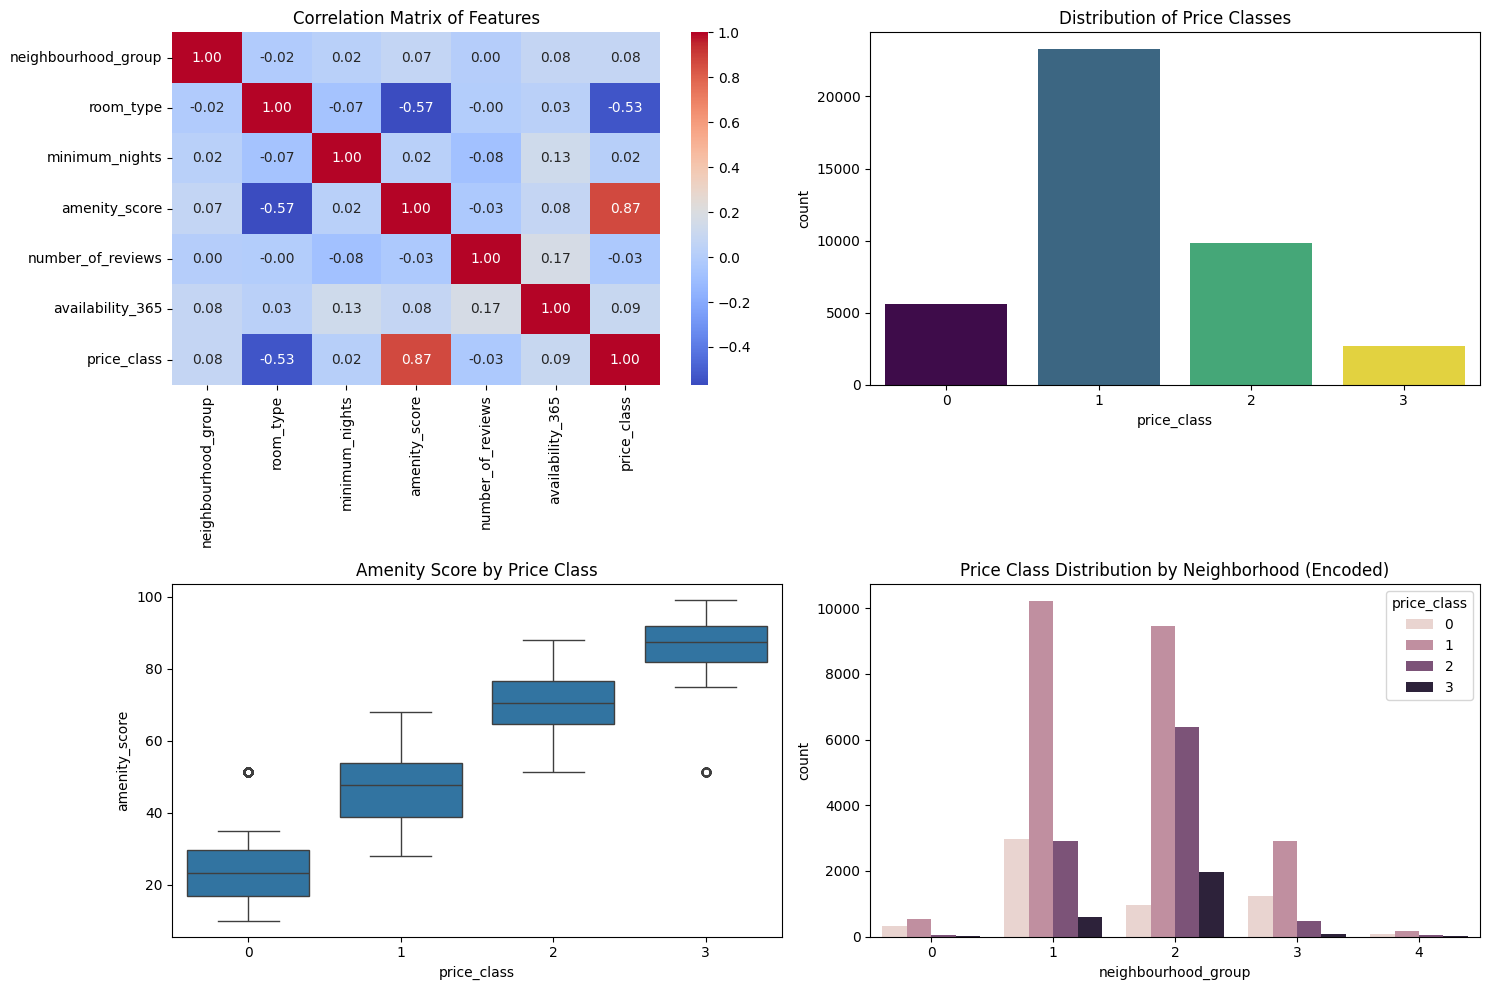

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import json

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

def impute_data(df):
    df['neighbourhood_group'] = df['neighbourhood_group'].fillna(df['neighbourhood_group'].mode()[0])
    df['room_type'] = df['room_type'].fillna(df['room_type'].mode()[0])

    df['minimum_nights'] = df['minimum_nights'].fillna(df['minimum_nights'].median())
    df['amenity_score'] = df['amenity_score'].fillna(df['amenity_score'].median())
    df['availability_365'] = df['availability_365'].fillna(df['availability_365'].median())

    df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
    return df

train_df = impute_data(train_df)
test_df = impute_data(test_df)

le_neighbourhood = LabelEncoder()
le_room = LabelEncoder()
le_neighbourhood.fit(train_df['neighbourhood_group'])
le_room.fit(train_df['room_type'])

train_df['neighbourhood_group'] = le_neighbourhood.transform(train_df['neighbourhood_group'])
train_df['room_type'] = le_room.transform(train_df['room_type'])

test_df['neighbourhood_group'] = le_neighbourhood.transform(test_df['neighbourhood_group'])
test_df['room_type'] = le_room.transform(test_df['room_type'])

plt.figure(figsize=(15, 10))

# Plot 1: Feature Correlation Heatmap
plt.subplot(2, 2, 1)
correlation_matrix = train_df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Matrix of Features")

# Plot 2: Class Balance
plt.subplot(2, 2, 2)
sns.countplot(x='price_class', data=train_df, palette='viridis', hue='price_class', legend=False)
plt.title("Distribution of Price Classes")

# Plot 3: Amenity Score by Price Class
plt.subplot(2, 2, 3)
sns.boxplot(x='price_class', y='amenity_score', data=train_df)
plt.title("Amenity Score by Price Class")

# Plot 4: Price Class by Neighborhood
plt.subplot(2, 2, 4)
sns.countplot(x='neighbourhood_group', hue='price_class', data=train_df)
plt.title("Price Class Distribution by Neighborhood (Encoded)")

plt.tight_layout()
plt.show()

# Scale numerical features
scaler = StandardScaler()
feature_cols = ['minimum_nights', 'number_of_reviews', 'amenity_score', 'availability_365']
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

train_df.to_csv("train_encoded.csv", index=False)
test_df.to_csv("test_encoded.csv", index=False)

encoding_dict = {
    'neighbourhood_group': dict(enumerate(le_neighbourhood.classes_)),
    'room_type': dict(enumerate(le_room.classes_))
}
with open('encoding_dict.json', 'w') as f:
    json.dump(encoding_dict, f)

In [ ]:
import numpy as np

def softmax(x)-> np.ndarray:
    # Subtracting the max for numerical stability (prevents overflow)
    # results in the same prob dist so no harm done!
    exps = np.exp(x - np.max(x, axis=0, keepdims=True))
    return exps / np.sum(exps, axis=0, keepdims=True)

def sigmoid(x)-> np.ndarray:
    # again done for stability, it all results in a number extremely close to +1 or -1
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x)-> np.ndarray:
    z = sigmoid(x)
    return z * (1 - z)

def relu(x)-> np.ndarray:
    return np.maximum(0, x)

def relu_derivative(x) -> np.ndarray:
    return (x > 0).astype(np.float32)

def categorical_cross_entropy(y_true, y_pred):
    # y_true is expected to be one-hot encoded (classes x Batch)
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=0))


class Layer:
    def __init__(self, in_shape, out_shape,activation_type='relu'):
        # np.sqrt(2.0 / in_shape) is taken from the pytorch documentation and is known as He intialization
        # https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_
        # You can comment it out however it will lead to worse results
        # the gains for relu are sqrt(2) and sigmoid is 1
        gain = 2.0 ** 0.5 if activation_type == 'relu' else 1
        self.weights = np.random.randn(out_shape, in_shape,) *  (gain * np.sqrt(2.0 / (out_shape + in_shape)))
        self.bias = np.zeros((out_shape, 1))
        self.net: np.ndarray | None = None
        self.output: np.ndarray | None = None
        self.grad_w = np.zeros_like(self.weights)
        self.grad_b = np.zeros_like(self.bias)

    def __call__(self, x) -> np.ndarray:
        return np.dot(self.weights, x) + self.bias

"""
This design is slightly inspired from pytorch
"""
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation_type='relu'):
        self.l1 = Layer(input_size, hidden_size,activation_type)
        self.l2 = Layer(hidden_size, hidden_size,activation_type) # maybe change this to whatever your heart desires
        self.l3 = Layer(hidden_size, output_size,activation_type)
        self.layers = [self.l1, self.l2, self.l3]
        self.activation_type = activation_type
        self.act = sigmoid if activation_type == 'sigmoid' else relu
        self.act_der = sigmoid_derivative if activation_type == 'sigmoid' else relu_derivative
        self.grad_history = {0: [], 1: []}
        self.feature_importance = np.zeros((input_size, 1))

    def forward(self, x):
        self.input = x
        z1 = self.l1(x)
        a1 = self.act(z1)
        self.l1.net = z1
        self.l1.output = a1

        z2 = self.l2(a1)
        a2 = self.act(z2)
        self.l2.net = z2
        self.l2.output = a2

        z3 = self.l3(a2)
        a3 = softmax(z3)
        self.l3.net = z3
        self.l3.output = a3

        return a3

    def backward(self, target, prediction):
        # This trick is taken from https://benjaminroland.onrender.com/coding&data/the-rational-of-softmax/
        delta = prediction - target
        batch_size = target.shape[1]

        for i in range(len(self.layers)-1,-1,-1): # fancy ahh way of starting from last layer
            # remember if i=0 we are at the input layer otherwise we've got stuff to do
            curr_layer = self.layers[i]
            prev_out = self.layers[i-1].output if i > 0 else self.input

            curr_layer.grad_w = np.dot(delta, prev_out.T) / batch_size
            curr_layer.grad_b = np.mean(delta, axis=1, keepdims=True)

            if i < 2:
                self.grad_history[i].append(np.mean(np.abs(curr_layer.grad_w)))
            # would be kind of interesting to propagate the gradiants to the input
            if i > 0:
                # Delta_prev = (W_curr.T dot Delta_curr) * activation_derivative(z_prev)
                # this is just carrying that gradiant back for us
                delta = np.dot(curr_layer.weights.T, delta) * self.act_der(self.layers[i-1].net)
            if i == 0:
              input_grad = np.dot(curr_layer.weights.T, delta)
              self.feature_importance = np.mean(np.abs(input_grad), axis=1, keepdims=True)

    def step(self, lr=0.01):
        for layer in self.layers:
            layer.weights -= lr * layer.grad_w
            layer.bias -= lr * layer.grad_b
        # everyone forgets to zero out grads
        for layer in self.layers:
            layer.grad_w = np.zeros_like(layer.grad_w)
            layer.grad_b = np.zeros_like(layer.grad_b)

if __name__ == "__main__":
    # just a quick test to see if the code runs and the network improves or not
    # this was written by co-pilot
    nn = NeuralNetwork(2, 6, 2)
    x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
    y = np.array([[1, 0], [0, 1], [0, 1], [1, 0]]).T
    for epoch in range(1000):
        pred = nn.forward(x)
        loss = categorical_cross_entropy(y, pred)
        print(f"Epoch {epoch}, Loss: {loss:.5f}, Pred: {pred[0]}, Target: {y[0]}")
        nn.backward(y, pred)
        nn.step(lr=0.1)

Epoch 0, Loss: 0.70323, Pred: [0.5        0.56703479 0.51887215 0.57633627], Target: [1 0 0 1]
Epoch 1, Loss: 0.70062, Pred: [0.49793913 0.56018247 0.5125741  0.56824966], Target: [1 0 0 1]
Epoch 2, Loss: 0.69738, Pred: [0.49623521 0.55438614 0.50604732 0.56260329], Target: [1 0 0 1]
Epoch 3, Loss: 0.69472, Pred: [0.49474444 0.5495228  0.50186573 0.55944331], Target: [1 0 0 1]
Epoch 4, Loss: 0.69209, Pred: [0.49340331 0.54385106 0.49606006 0.5533832 ], Target: [1 0 0 1]
Epoch 5, Loss: 0.68995, Pred: [0.49234142 0.5397368  0.49171297 0.54960234], Target: [1 0 0 1]
Epoch 6, Loss: 0.68762, Pred: [0.49142424 0.53478462 0.4868437  0.54465941], Target: [1 0 0 1]
Epoch 7, Loss: 0.68539, Pred: [0.49070307 0.53151038 0.48407713 0.54356305], Target: [1 0 0 1]
Epoch 8, Loss: 0.68353, Pred: [0.49007452 0.52707175 0.47874758 0.5376223 ], Target: [1 0 0 1]
Epoch 9, Loss: 0.68150, Pred: [0.48966135 0.52431756 0.47693821 0.53746259], Target: [1 0 0 1]
Epoch 10, Loss: 0.67935, Pred: [0.48930676 0.52067

Epoch 0
Train - ReLU Loss: 0.81330, Acc: 0.6983 | Sigmoid Loss: 1.11071, Acc: 0.5511
Val   - ReLU Loss: 0.54740, Acc: 0.7786 | Sigmoid Loss: 1.08116, Acc: 0.5688
Feature Importance (ReLU):[[0.15695848]
 [0.27010412]
 [0.11571713]
 [0.61603017]
 [0.11698958]
 [0.14715465]]
Feature Importance (Sigmoid): [[0.00624424]
 [0.00574968]
 [0.00660665]
 [0.0263491 ]
 [0.02024738]
 [0.00946043]]
Relu Grad History Layer 1: 0.023424476220530798, Layer 2: 0.010215971474925596
Sigmoid Grad History Layer 1: 0.0018769542165300813, Layer 2: 0.0029435957306195746
Epoch 1
Train - ReLU Loss: 0.49539, Acc: 0.7936 | Sigmoid Loss: 1.08107, Acc: 0.5620
Val   - ReLU Loss: 0.44401, Acc: 0.8110 | Sigmoid Loss: 1.06287, Acc: 0.5688
Feature Importance (ReLU):[[0.13044594]
 [0.24802677]
 [0.08732042]
 [0.79063448]
 [0.09480771]
 [0.1507887 ]]
Feature Importance (Sigmoid): [[0.00890028]
 [0.0129081 ]
 [0.00620357]
 [0.04745802]
 [0.02464776]
 [0.01125751]]
Relu Grad History Layer 1: 0.02279832063827809, Layer 2: 0.00

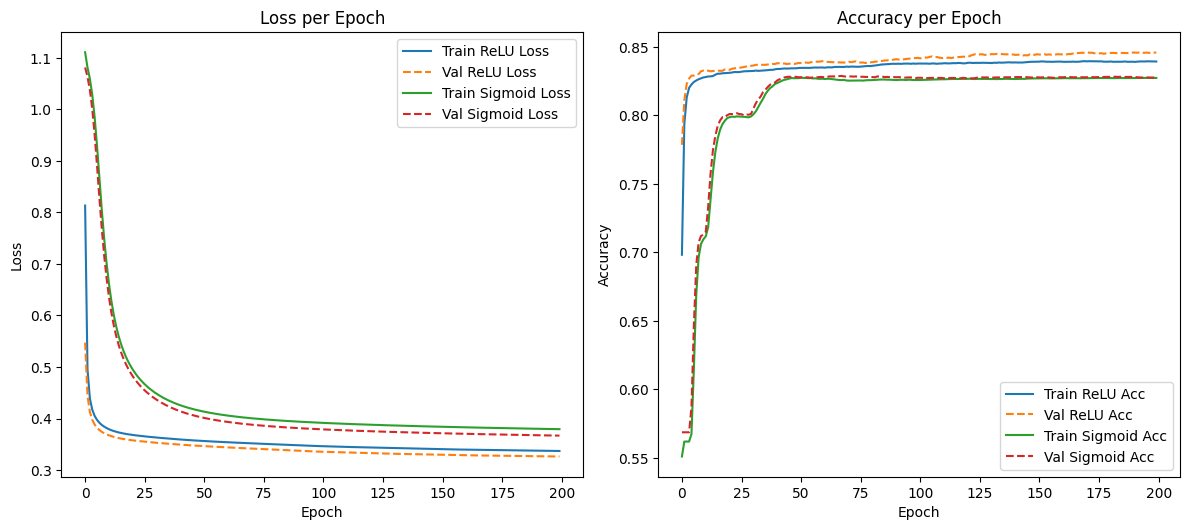

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_full = pd.read_csv("train_encoded.csv")

val_split = 0.2
val_size = int(len(train_full) * val_split)
train = train_full.iloc[:-val_size]
val = train_full.iloc[-val_size:]

x_train = train.drop('price_class', axis=1).values.T
y_train = pd.get_dummies(train['price_class']).values.T

x_val = val.drop('price_class', axis=1).values.T
y_val = pd.get_dummies(val['price_class']).values.T

BATCH_SIZE = 64

nn_relu = NeuralNetwork(input_size=x_train.shape[0], hidden_size=32, output_size=y_train.shape[0], activation_type='relu')
nn_sigmoid = NeuralNetwork(input_size=x_train.shape[0], hidden_size=32, output_size=y_train.shape[0], activation_type='sigmoid')

relu_loss_history = []
sigmoid_loss_history = []
relu_acc_history = []
sigmoid_acc_history = []

relu_val_loss_history = []
sigmoid_val_loss_history = []
relu_val_acc_history = []
sigmoid_val_acc_history = []

for epoch in range(200):
    running_relu_loss = 0
    running_sigmoid_loss = 0
    running_acc_relu = 0
    running_acc_sigmoid = 0

    for i in range(0, x_train.shape[1], BATCH_SIZE):
        x_batch = x_train[:, i:i+BATCH_SIZE]
        y_batch = y_train[:, i:i+BATCH_SIZE]

        pred_relu = nn_relu.forward(x_batch)
        pred_sigmoid = nn_sigmoid.forward(x_batch)

        loss_relu = categorical_cross_entropy(y_batch, pred_relu)
        loss_sigmoid = categorical_cross_entropy(y_batch, pred_sigmoid)

        running_relu_loss += loss_relu
        running_sigmoid_loss += loss_sigmoid

        acc_relu = np.mean(np.argmax(pred_relu, axis=0) == np.argmax(y_batch, axis=0))
        acc_sigmoid = np.mean(np.argmax(pred_sigmoid, axis=0) == np.argmax(y_batch, axis=0))
        running_acc_relu += acc_relu
        running_acc_sigmoid += acc_sigmoid

        nn_relu.backward(y_batch, pred_relu)
        nn_sigmoid.backward(y_batch, pred_sigmoid)
        nn_relu.step(lr=0.01)
        nn_sigmoid.step(lr=0.01)

    pred_val_relu = nn_relu.forward(x_val)
    pred_val_sigmoid = nn_sigmoid.forward(x_val)

    val_loss_relu = categorical_cross_entropy(y_val, pred_val_relu)
    val_loss_sigmoid = categorical_cross_entropy(y_val, pred_val_sigmoid)

    val_acc_relu = np.mean(np.argmax(pred_val_relu, axis=0) == np.argmax(y_val, axis=0))
    val_acc_sigmoid = np.mean(np.argmax(pred_val_sigmoid, axis=0) == np.argmax(y_val, axis=0))

    total_steps = (x_train.shape[1] / BATCH_SIZE)
    epoch_relu_acc = running_acc_relu / total_steps
    epoch_sigmoid_acc = running_acc_sigmoid / total_steps
    epoch_relu_loss = running_relu_loss / total_steps
    epoch_sigmoid_loss = running_sigmoid_loss / total_steps

    relu_loss_history.append(epoch_relu_loss)
    sigmoid_loss_history.append(epoch_sigmoid_loss)
    relu_acc_history.append(epoch_relu_acc)
    sigmoid_acc_history.append(epoch_sigmoid_acc)

    relu_val_loss_history.append(val_loss_relu)
    sigmoid_val_loss_history.append(val_loss_sigmoid)
    relu_val_acc_history.append(val_acc_relu)
    sigmoid_val_acc_history.append(val_acc_sigmoid)

    print(f"Epoch {epoch}")
    print(f"Train - ReLU Loss: {epoch_relu_loss:.5f}, Acc: {epoch_relu_acc:.4f} | Sigmoid Loss: {epoch_sigmoid_loss:.5f}, Acc: {epoch_sigmoid_acc:.4f}")
    print(f"Val   - ReLU Loss: {val_loss_relu:.5f}, Acc: {val_acc_relu:.4f} | Sigmoid Loss: {val_loss_sigmoid:.5f}, Acc: {val_acc_sigmoid:.4f}")
    print(f"Feature Importance (ReLU):{nn_relu.feature_importance}")
    print(f"Feature Importance (Sigmoid): {nn_sigmoid.feature_importance}")
    print(f"Relu Grad History Layer 1: {nn_relu.grad_history[0][-1] if nn_relu.grad_history[0] else 0}, Layer 2: {nn_relu.grad_history[1][-1] if nn_relu.grad_history[1] else 0}")
    print(f"Sigmoid Grad History Layer 1: {nn_sigmoid.grad_history[0][-1] if nn_sigmoid.grad_history[0] else 0}, Layer 2: {nn_sigmoid.grad_history[1][-1] if nn_sigmoid.grad_history[1] else 0}")

test = pd.read_csv("test_encoded.csv")
x_test = test.drop('price_class', axis=1).values.T
y_test = pd.get_dummies(test['price_class']).values.T
pred_test_relu = nn_relu.forward(x_test)
pred_test_sigmoid = nn_sigmoid.forward(x_test)
test_acc_relu = np.mean(np.argmax(pred_test_relu, axis=0) == np.argmax(y_test, axis=0))
test_acc_sigmoid = np.mean(np.argmax(pred_test_sigmoid, axis=0) == np.argmax(y_test, axis=0))
print(f"Test Accuracy ReLU: {test_acc_relu*100:.4f}, Sigmoid: {test_acc_sigmoid*100:.4f}")

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(relu_loss_history, label='Train ReLU Loss')
plt.plot(relu_val_loss_history, label='Val ReLU Loss', linestyle='--')
plt.plot(sigmoid_loss_history, label='Train Sigmoid Loss')
plt.plot(sigmoid_val_loss_history, label='Val Sigmoid Loss', linestyle='--')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(relu_acc_history, label='Train ReLU Acc')
plt.plot(relu_val_acc_history, label='Val ReLU Acc', linestyle='--')
plt.plot(sigmoid_acc_history, label='Train Sigmoid Acc')
plt.plot(sigmoid_val_acc_history, label='Val Sigmoid Acc', linestyle='--')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# This is the actual implementation of the feature importance algorithm from the book
# decided it was better to implement it sepearately instead of modifying the entire backward pass
def get_sensitivity(model, x_instance):
    output = model.forward(x_instance)
    winning_class = np.argmax(output, axis=0)
    num_classes = output.shape[0]
    batch_size = x_instance.shape[1]
    delta = np.zeros_like(output)
    # constructing the vector we need to backpropagate which  should only have one in the place of the winning class
    for b in range(batch_size):
        delta[winning_class[b], b] = 1.0

    delta = np.dot(model.l3.weights.T, delta) * model.act_der(model.l2.output)
    delta = np.dot(model.l2.weights.T, delta) * model.act_der(model.l1.output)
    input_sensitivity = np.dot(model.l1.weights.T, delta)
    return np.abs(input_sensitivity)

sample_x = x_test[:, 0:1]
sensitivity = get_sensitivity(nn_relu, sample_x)

for i, val in enumerate(sensitivity.flatten()):
    print(f"Feature {i}: {val:.5f}")

Feature 0: 0.03462
Feature 1: 0.87658
Feature 2: 0.80778
Feature 3: 12.43256
Feature 4: 1.24498
Feature 5: 0.06401
